### モジュール，　データフレームの読み込み

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn as sns

In [15]:
# データの読み込みと日付を変換
data = pd.read_csv('../data/Tokyo_Weather_2013-2023/Compiled_2013-2023_eng.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

天気の予想に必要そうな気象パラメータ: 
weather_parameters = [
        'SunshineDuration', 'AverageWindSpeed', 'AverageHumidity',
        'AverageSeaLevelPressure', 'AverageTemperature', 'TotalSolarRadiation',
        'TotalPrecipitation', 'MaximumTemperature', 'MinimumTemperature',
        'MaximumWindSpeed', 'MaximumInstantaneousWindSpeed'
    ]

### 季節性，　トレンド，　自己相関をプロット

In [16]:
def process_time_series(data, column_name):
    # 列に欠損値が含まれているかどうかをチェック
    if data[column_name].isnull().any():
        print(f"Error: The column '{column_name}' contains missing values.") # 欠損値がある場合にエラーメッセージを出力
        return

    # トレンド，季節性をプロット(seasonal_decomposeを使用)
    decomposition = seasonal_decompose(
        data[column_name], model='additive', period=365
        ) # 季節性、トレンド、残差成分にデータを分解
    fig = decomposition.plot()
    fig.set_size_inches(12, 6)
    plt.show()
    
    # トレンド，季節性をプロット(STLを使用, 周期=365日)
    result1=STL(data[column_name], period=365, robust=True)  # 季節性、トレンド、残差成分にデータを分解
    fig = result1.fit()
    fig.plot()
    plt.gcf().set_size_inches(12, 6)
    plt.show()

    # ACF，PACFのプロット
    fig, (ax1, ax2) = plt.subplots(2, 1)
    plot_acf(data[column_name], lags=50, ax=ax1) # 自己相関をプロット
    plot_pacf(data[column_name], lags=50, ax=ax2) # 偏自己相関をプロット
    fig.set_size_inches(12, 6)
    plt.show()

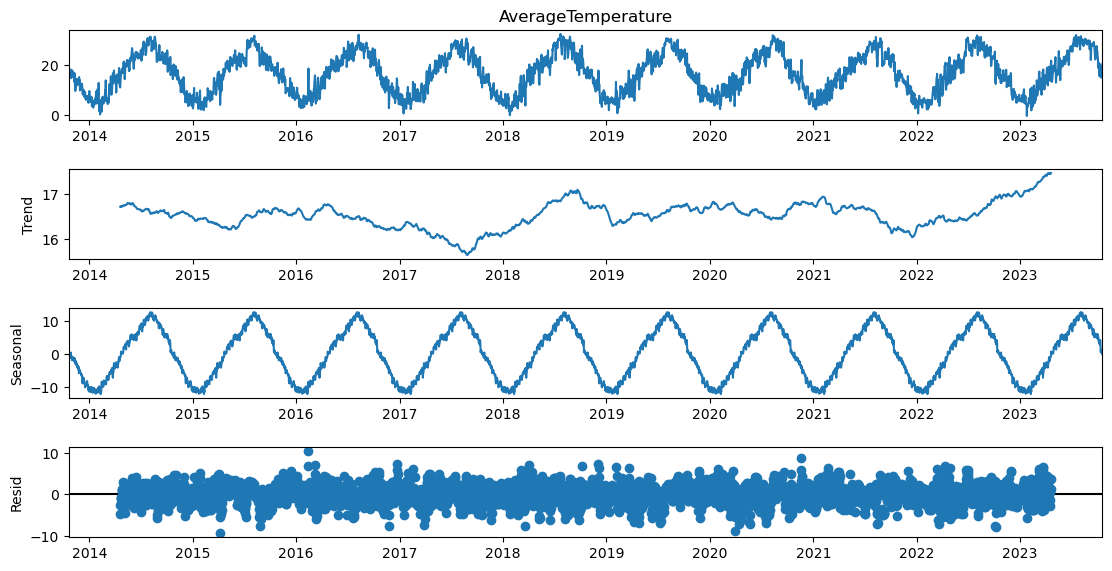

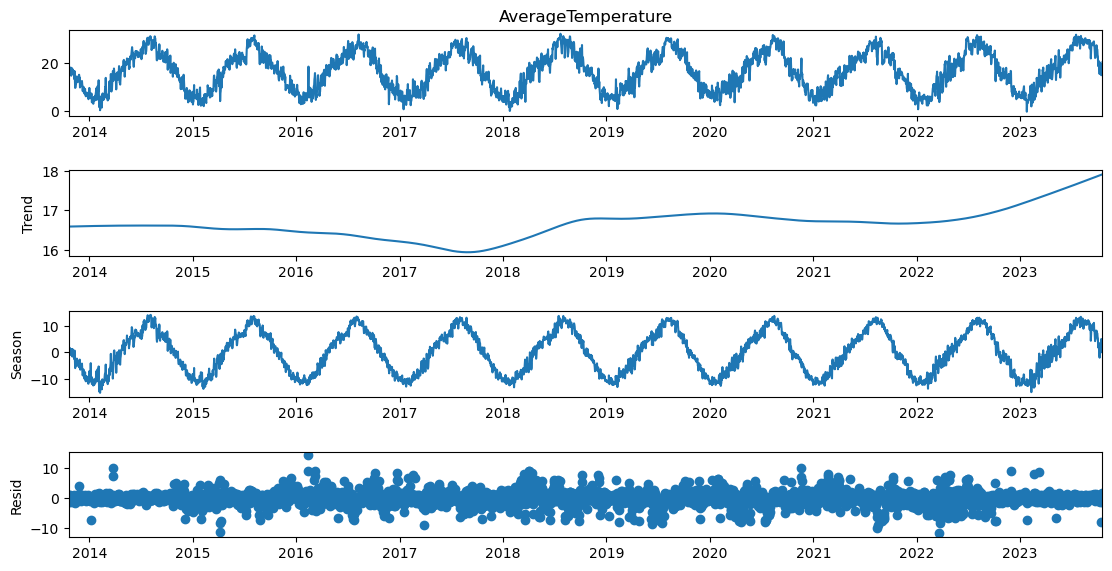

/Users/taku/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


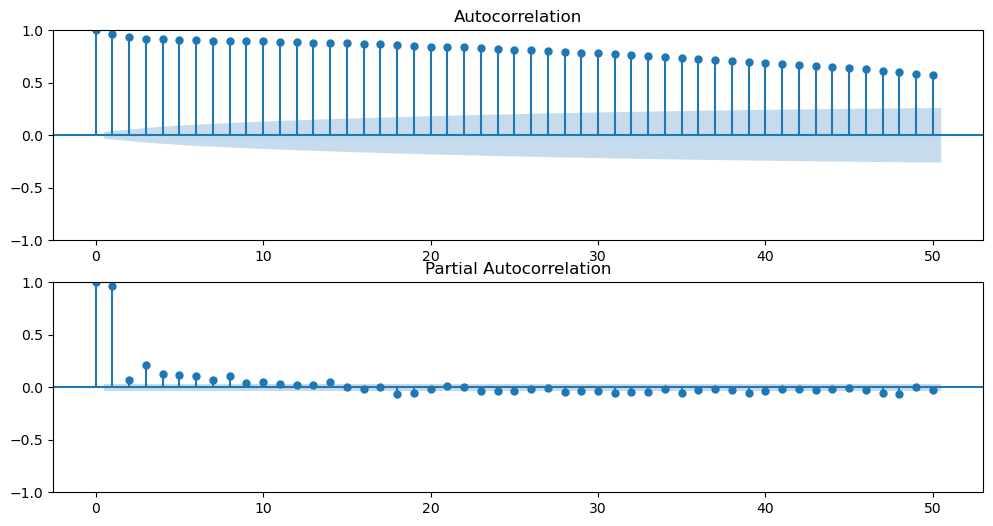

In [17]:

process_time_series(data, 'AverageTemperature')

### 天気の概況からHeatmapのプロット
天気の概況をカテゴリに分け，各天気の出現頻度をHeatmapを用いて図示

In [18]:
# 天気の概況をカテゴリーに分類
def classify_weather(condition, code):
    if not condition:  # 空の文字列の場合は終了
        return code
    word = condition[0]  # 最初の文字を取得
    # 天気のコードに対応する辞書
    weather_dict = {
        '快': 1, # 快晴
        '晴': 2, # 晴
        '大': 3, # 大雨
        '雨': 4, # 雨
        'み': 5, # みぞれ
        '雪': 6, # 雪
        '薄': 7, # 薄曇
        '曇': 8, # 曇
        '霧': 9, # 霧
        '雷': 10, # 雷
        'ひ': 11, # ひょう
        '時': 12, # 時々
        '後': 13, # 後
        '一': 14, # 一時
    }
    
    if word == '・' or word == '、': # ・や、がある場合は除去
        next_index = 1
        return classify_weather(condition[next_index:], code)
    
    if word in weather_dict:
        code.append(weather_dict[word])  # コードを追加
        # 次のインデックスを決定
        if word in ['晴', '雨', '雪', '曇', '霧', '雷', '後']:
            next_index = 1
        elif word in ['快', '大', '薄', '時', '一']:
            next_index = 2
        elif word in ['み', 'ひ']:
            next_index = 3
        else:
            next_index = 1 # 安全のために設定
        return classify_weather(condition[next_index:], code)  # 次の文字列で再帰呼び出し
    else:
        return code  # 条件に一致しない場合は現在のコードを返す
    
# すべての天気をカテゴリーに分類して返答する
def classify_weather_wrapper(condition):
    code = []
    return classify_weather(condition, code)


In [19]:
def heatmap_weather_category(data, categories_name):
    # 天気のカテゴリーを数えるためのデータフレームを作成
    categories = sorted(list(set([item for sublist in data[categories_name] for item in sublist])))
    weather_matrix = pd.DataFrame(0, index=pd.date_range(start=data.index.min(), end=data.index.max()), columns=categories)

    # 更新された天気のカテゴリー辞書
    weather_dict = {
        1: 'Clear',        # 快晴 - Clear
        2: 'Sunny',        # 晴 - Sunny
        3: 'Heavy Rain',   # 大雨 - Heavy Rain
        4: 'Rain',         # 雨 - Rain
        5: 'Sleet',        # みぞれ - Sleet
        6: 'Snow',         # 雪 - Snow
        7: 'Partly Cloudy',# 薄曇 - Partly Cloudy
        8: 'Cloudy',       # 曇 - Cloudy
        9: 'Fog',          # 霧 - Fog
        10: 'Thunder',     # 雷 - Thunder
        11: 'Hail'         # ひょう - Hail
    }

    # 各日付について、天気カテゴリーの発生回数をカウント
    for index, row in data.iterrows():
        for category in row[categories_name]:
            weather_matrix.at[index, category] += 1

    # 月毎のデータに集約
    monthly_weather = weather_matrix.resample('M').sum()

    existing_categories = weather_matrix.columns.intersection(weather_dict.keys())
    filtered_weather_matrix = monthly_weather[existing_categories]
    filtered_weather_matrix.columns = [weather_dict[category] for category in existing_categories]

    filtered_dict = {k: weather_dict[k] for k in existing_categories if k in weather_dict}
    weather_matrix_filtered = weather_matrix.loc['2013-10-20':'2023-10-19']

    # フィルターにかけたデータを，すべての年にわたって各月ごとに再集計する
    monthly_totals = weather_matrix_filtered.groupby([weather_matrix_filtered.index.month]).sum()

    # 辞書に存在するカテゴリーだけを含むように、月次合計をフィルタリングする
    monthly_totals = monthly_totals[filtered_dict.keys()]

    # 数値のカテゴリを、辞書の対応する名前で置き換える
    monthly_totals.columns = [filtered_dict[category] for category in monthly_totals.columns]
    plt.figure(figsize=(20, 10))
    sns.heatmap(monthly_totals.T, cmap='Blues', linewidths=.5, annot=True, fmt='d')
    plt.title('Monthly Weather Category Totals from 2013-10-20 to 2023-10-19')
    plt.xlabel('Month')
    plt.ylabel('Weather Category')
    plt.yticks(rotation=0)  
    plt.tight_layout()  
    plt.show()

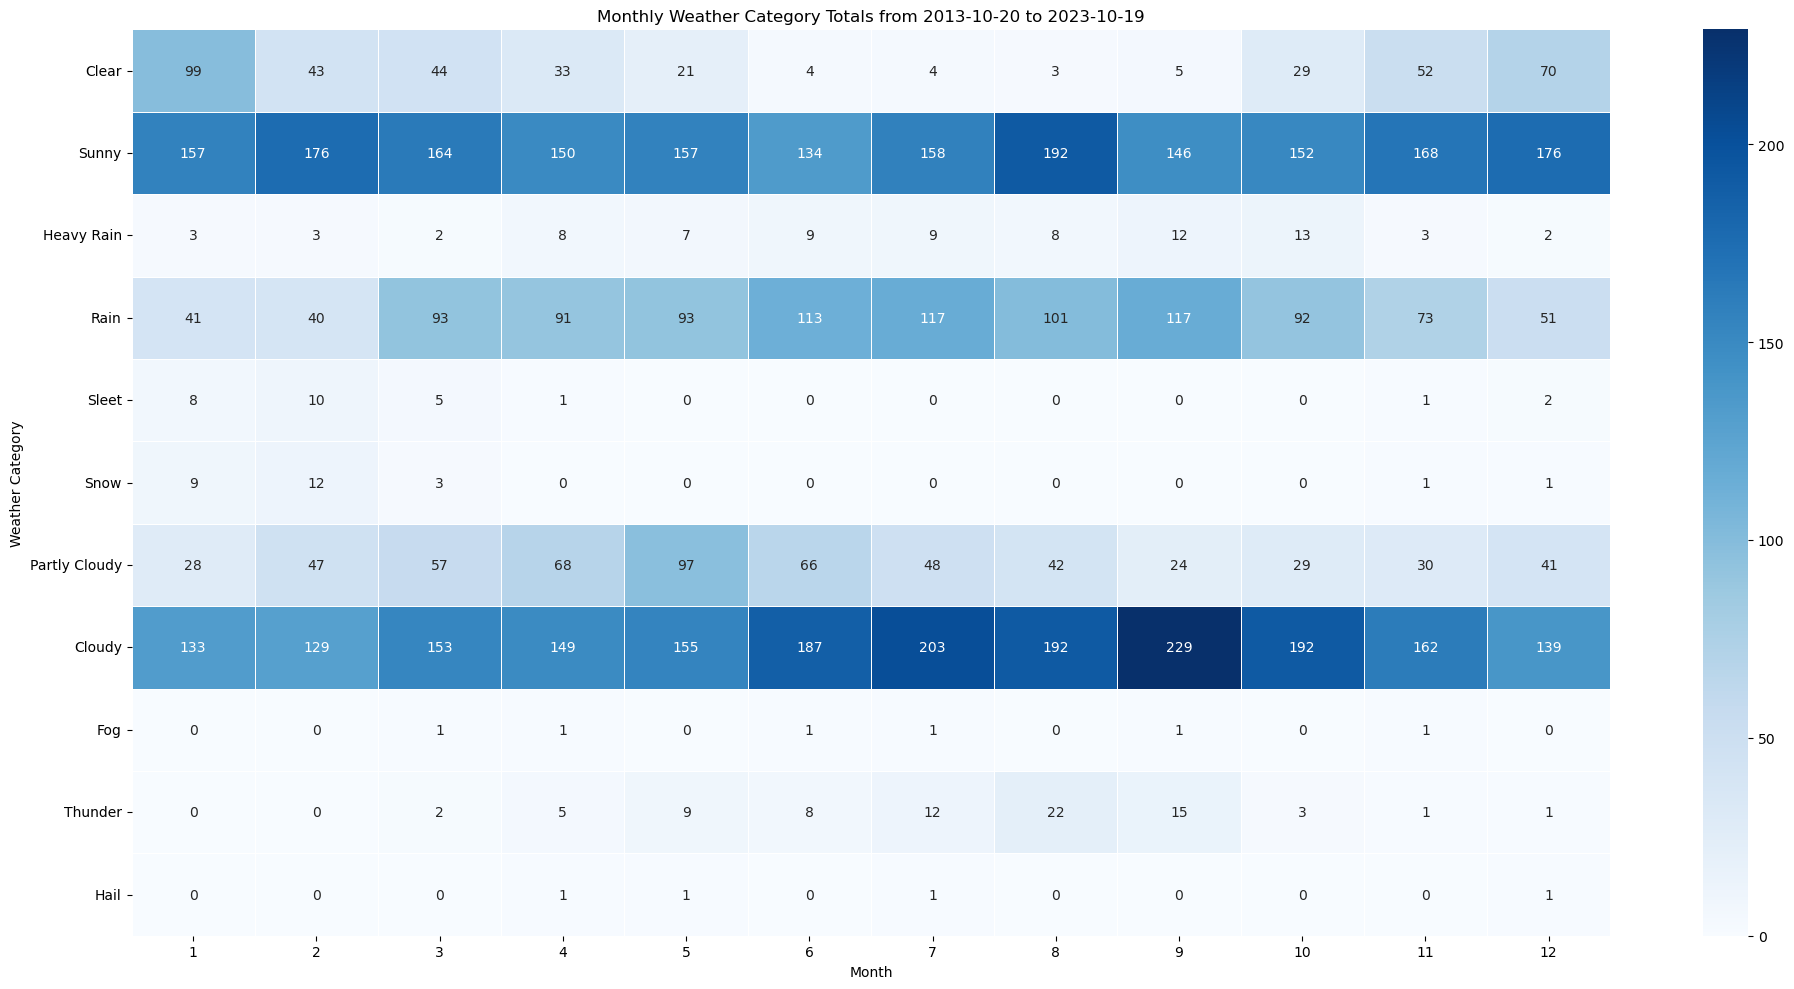

In [20]:
data['weather_category_day'] = data['WeatherSummaryDay'].apply(classify_weather_wrapper)
data['weather_category_night'] = data['WeatherSummaryNight'].apply(classify_weather_wrapper)
heatmap_weather_category(data, 'weather_category_day')
#heatmap_weather_category(data, 'weather_category_night')